In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *



# import ipywidgets as widgets
# from IPython.display import display, clear_output


Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "test_modelloader_sampling"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/configuration.json


# 2.  Data

In [3]:
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# Define the functions used in the DGP
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)

def f2(x3, x4):
    return np.exp(-((x3 - 1)**2 + (x4 - 1)**2))

def f3(x5, x6):
    return (x5 * x6) / (1 + x5**2 + x6**2)

def dgp_continuous_interactions(n_obs=1_000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)
    x4 = np.random.uniform(0, 2, size=n_obs)
    x5 = np.random.normal(0, 2, size=n_obs)
    x6 = np.random.uniform(0, 2, size=n_obs)
    x7 = np.random.normal(0, 2, size=n_obs)

    # Response variable with interactions
    y = f1(x1, x2) + f2(x3, x4) + f3(x5, x6) + 1.5 * x7

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': x6, 'x7': x7, 'x8': y})
    return df


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp_continuous_interactions()

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'continous','x2':'continous','x3':'continous','x4':'continous','x5':'continous','x6':'continous','x7':'continous','x8':'continous'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)


Loaded data from /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/test_modelloader_sampling.csv
Configuration updated successfully.


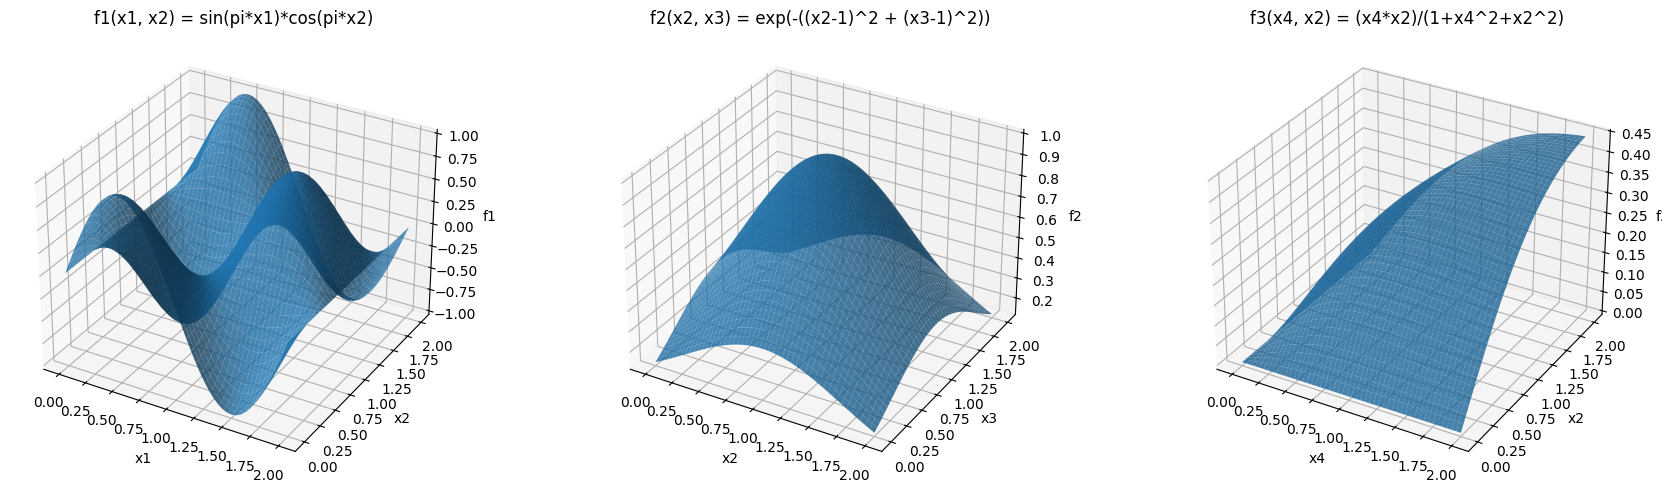

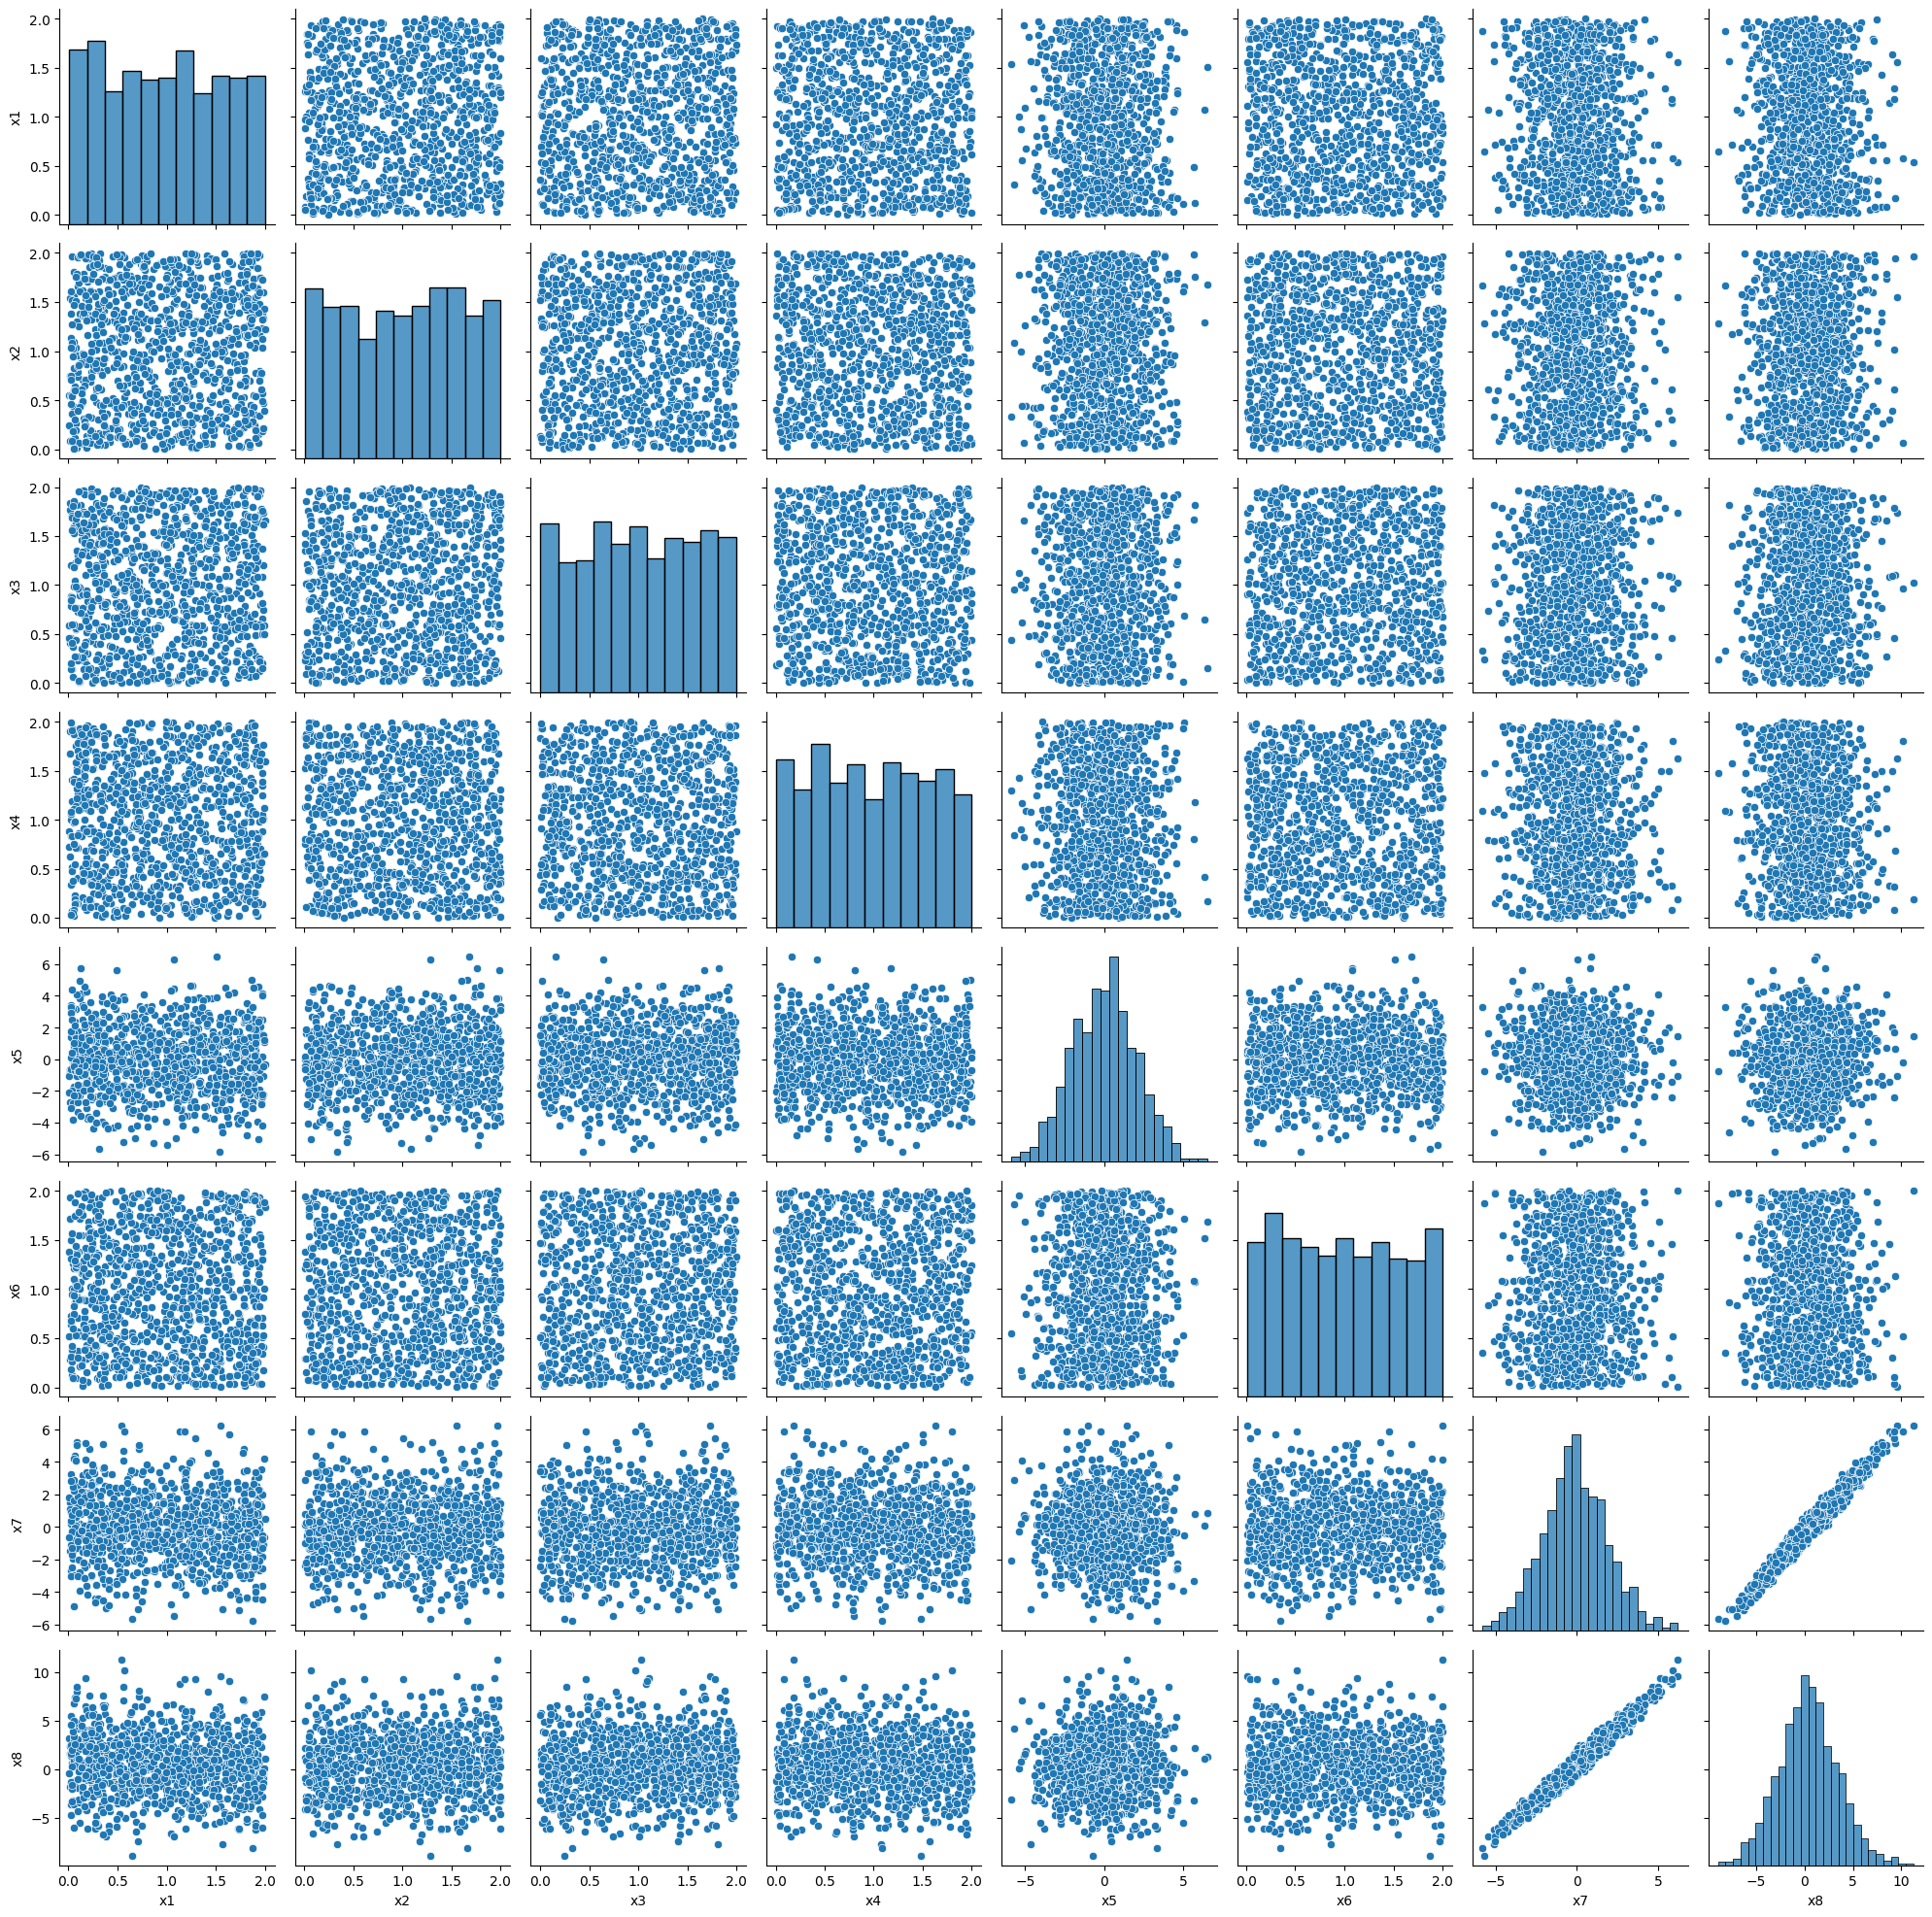

In [4]:

# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

# f2(x2, x3)
ax = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f2(x2, x3) = exp(-((x2-1)^2 + (x3-1)^2))")
ax.set_xlabel("x2")
ax.set_ylabel("x3")
ax.set_zlabel("f2")

# f3(x4, x2)
ax = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f3(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f3(x4, x2) = (x4*x2)/(1+x4^2+x2^2)")
ax.set_xlabel("x4")
ax.set_ylabel("x2")
ax.set_zlabel("f3")

plt.tight_layout()
plt.show()


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 800, Validation size: 100, Test size: 100


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/graph.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


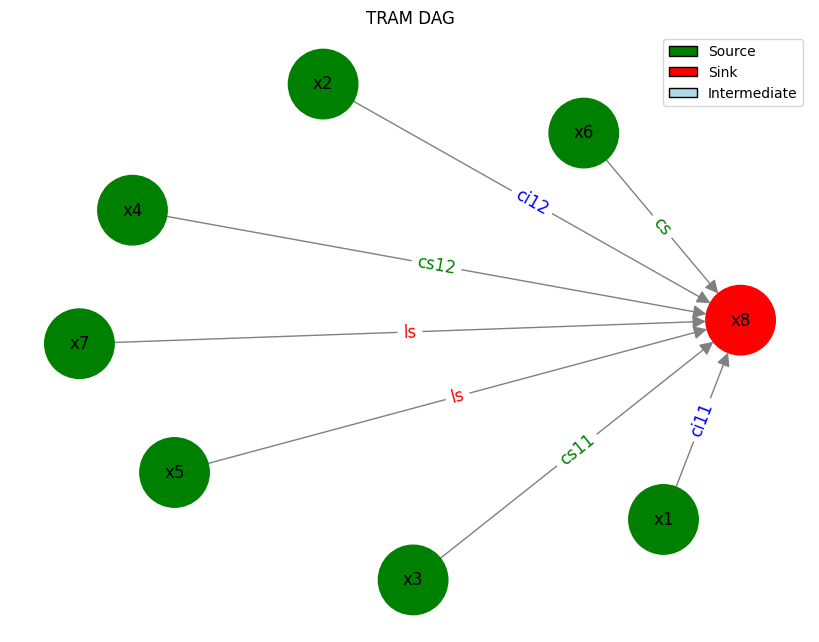

In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10) # TODO write from -> to 

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

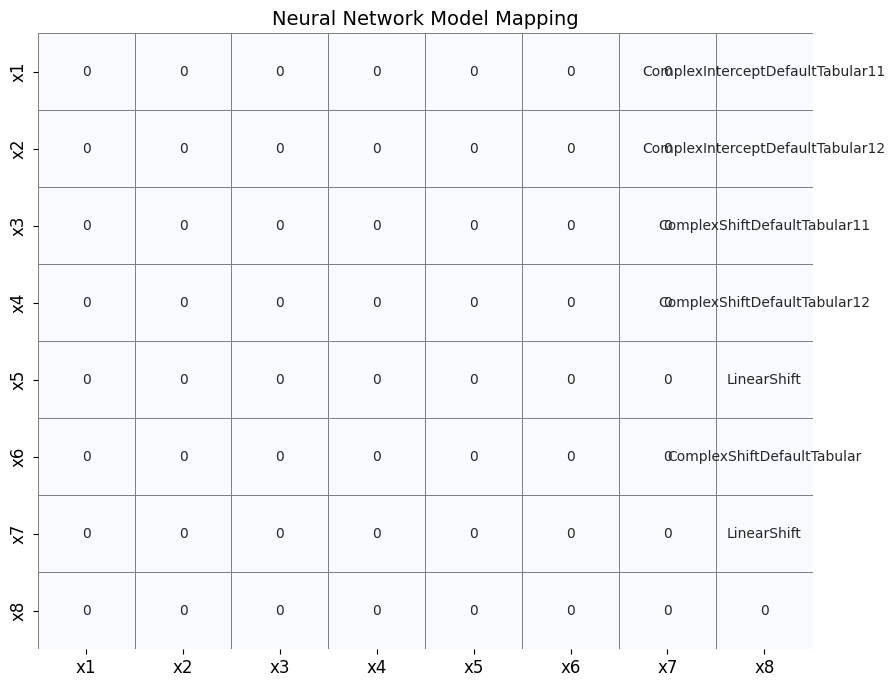

In [7]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [8]:
write_nodes_information_to_configuration_v3(CONF_DICT_PATH, min_vals, max_vals)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.10363289207947188, 'max': 1.8947268989877821, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.0961770772163077, 'max': 1.9152953885721604, 'transformation_term_nn_models_in_h()': {}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.1021798258863887, 'max': 1.9121695544111017, 'transformation_term_nn_models_in_h()': {}}, 'x4': {'Modelnr': 3, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.1012176500081761, 'max': 1.87272970393435, 'transformation_term_nn_models_in_h()': {}}, 'x5': {'Modelnr': 4, 'data_t

In [9]:
DEV_TRAINING=True
train_list=['x1','x2','x3','x4','x5','x6','x7','x8']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 2# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [10]:
# def check_if_training_complete(node, NODE_DIR, epochs):
#     """
#     Check if the training for the given node is complete.
#     Returns True if training is complete, False otherwise.
#     """
#     MODEL_PATH, _, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)
#     try:
#         if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
#             with open(TRAIN_HIST_PATH, 'r') as f:
#                 train_loss_hist = json.load(f)

#             start_epoch = len(train_loss_hist)
            
#             # return false if already trained to skip to the next node 
#             if start_epoch >= epochs:
#                 print(f"Node {node} already trained for {epochs} epochs. Skipping.")
#                 return False
#             else:
#                 print(f"Node {node} not trained yet or training incomplete. Starting from epoch {start_epoch}.")
#                 return True
#         else:
            
#             return True
        
#     except Exception as e:
#         print(f"Error checking training status for node {node}: {e}")
#         return False

In [11]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']


for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    
    ########################## 2. Create Model ##############################
    tram_model= get_fully_specified_tram_model_v5(node, target_nodes, verbose=True)

    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
        train_val_loop_v5(
                   node,
                   target_nodes,
                   NODE_DIR,
                   tram_model,
                   train_loader,
                   val_loader,
                   epochs,
                   optimizer,
                   use_scheduler,
                   scheduler,
                   save_linear_shifts=False,
                   verbose=1,
                   device=device)
    


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Node x1 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
Node x2 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
Node x3 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node: x4 ------------*-----------------*-------------------*--
Node x4 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node: x5 ------------*-----------------*-------------------*--
Node x5 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node: x6 ------------*-----------------*-------------------*--
Node x6 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node:

# 6 Inspect Training

## 6.1 Loss vs epochs

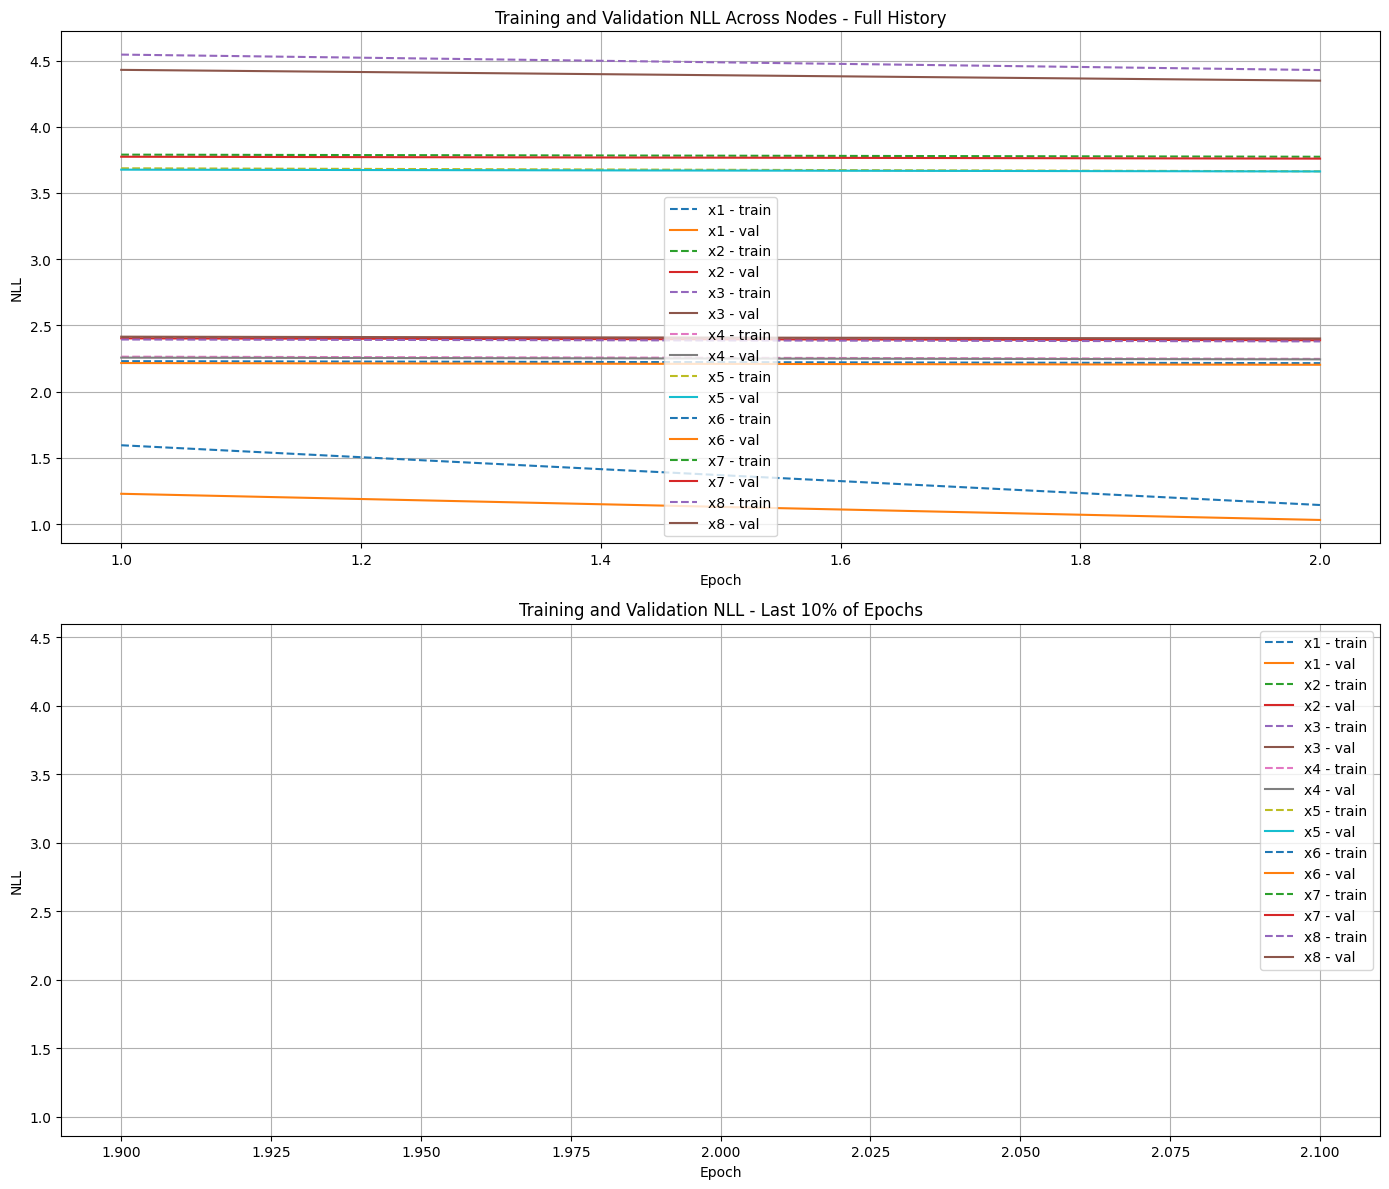

In [12]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


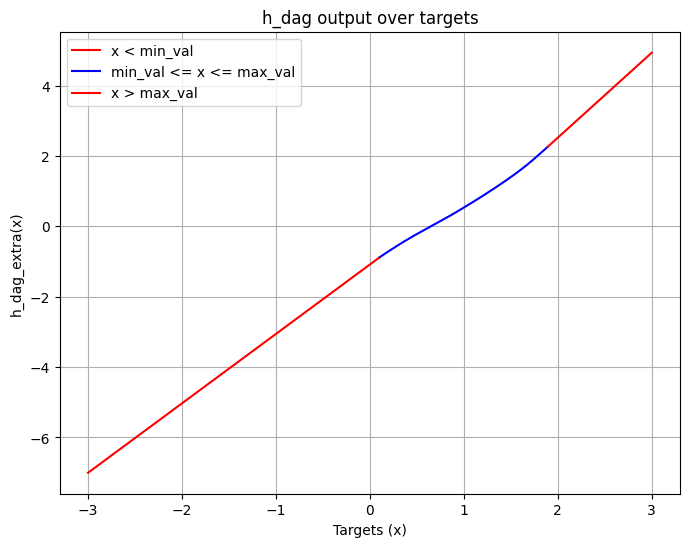


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--


h() for  x2:   0%|          | 0/1000 [00:00<?, ?it/s]


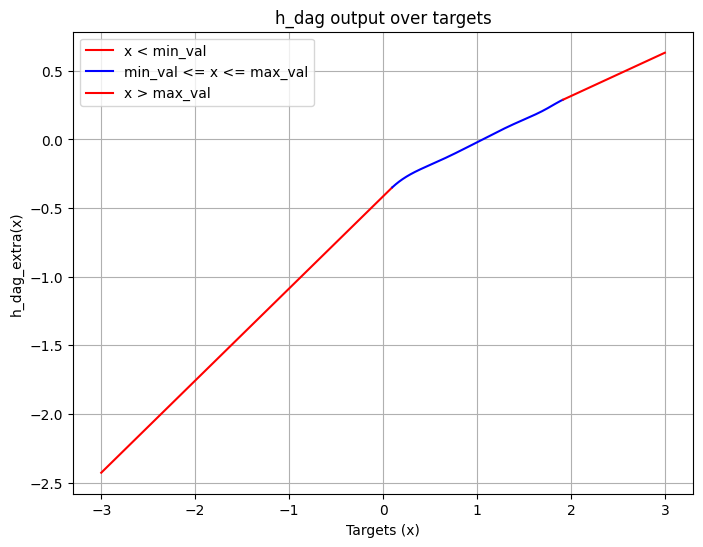


----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--


h() for  x3:   0%|          | 0/1000 [00:00<?, ?it/s]


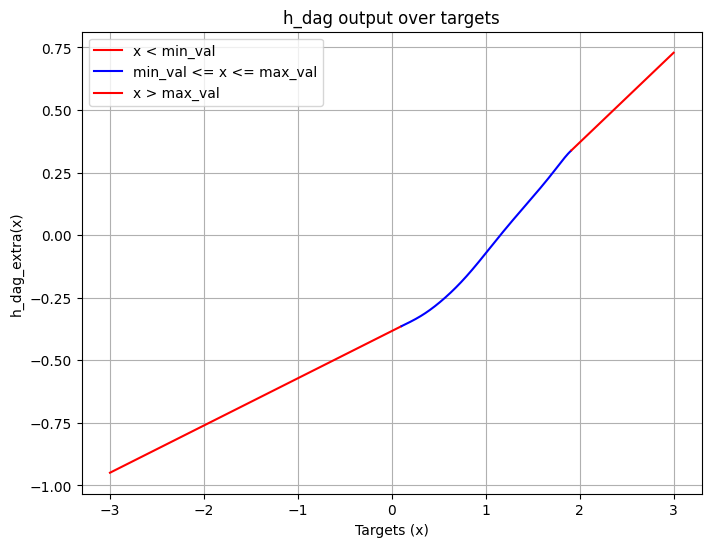


----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--


h() for  x4:   0%|          | 0/1000 [00:00<?, ?it/s]


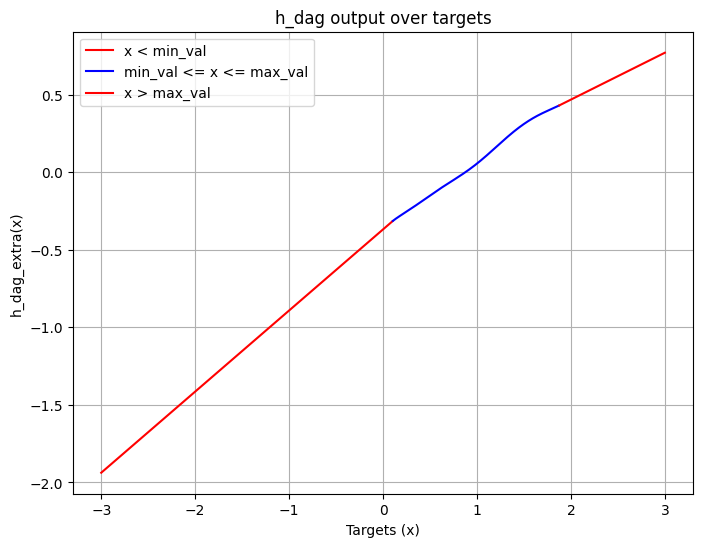


----*----------*-------------*--------Inspect TRAFO Node: x5 ------------*-----------------*-------------------*--


h() for  x5:   0%|          | 0/1000 [00:00<?, ?it/s]


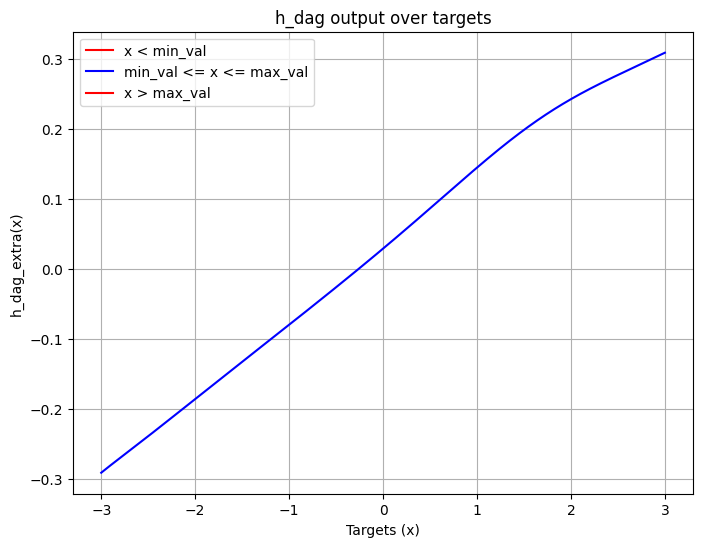


----*----------*-------------*--------Inspect TRAFO Node: x6 ------------*-----------------*-------------------*--


h() for  x6:   0%|          | 0/1000 [00:00<?, ?it/s]


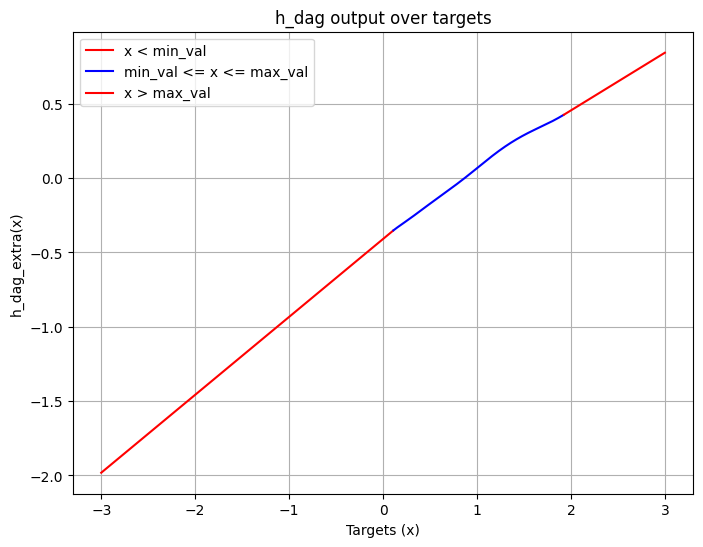


----*----------*-------------*--------Inspect TRAFO Node: x7 ------------*-----------------*-------------------*--


h() for  x7:   0%|          | 0/1000 [00:00<?, ?it/s]


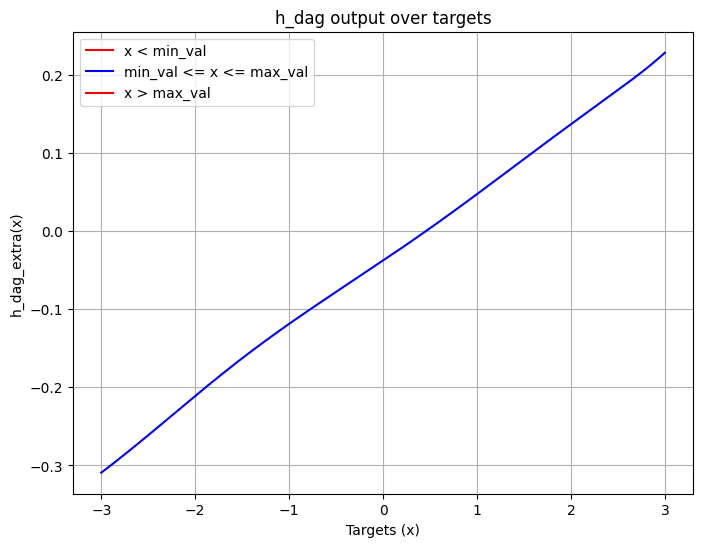


----*----------*-------------*--------Inspect TRAFO Node: x8 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [13]:
show_hdag_for_source_nodes_v3(target_nodes,EXPERIMENT_DIR,device,xmin_plot=-3,xmax_plot=3)

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


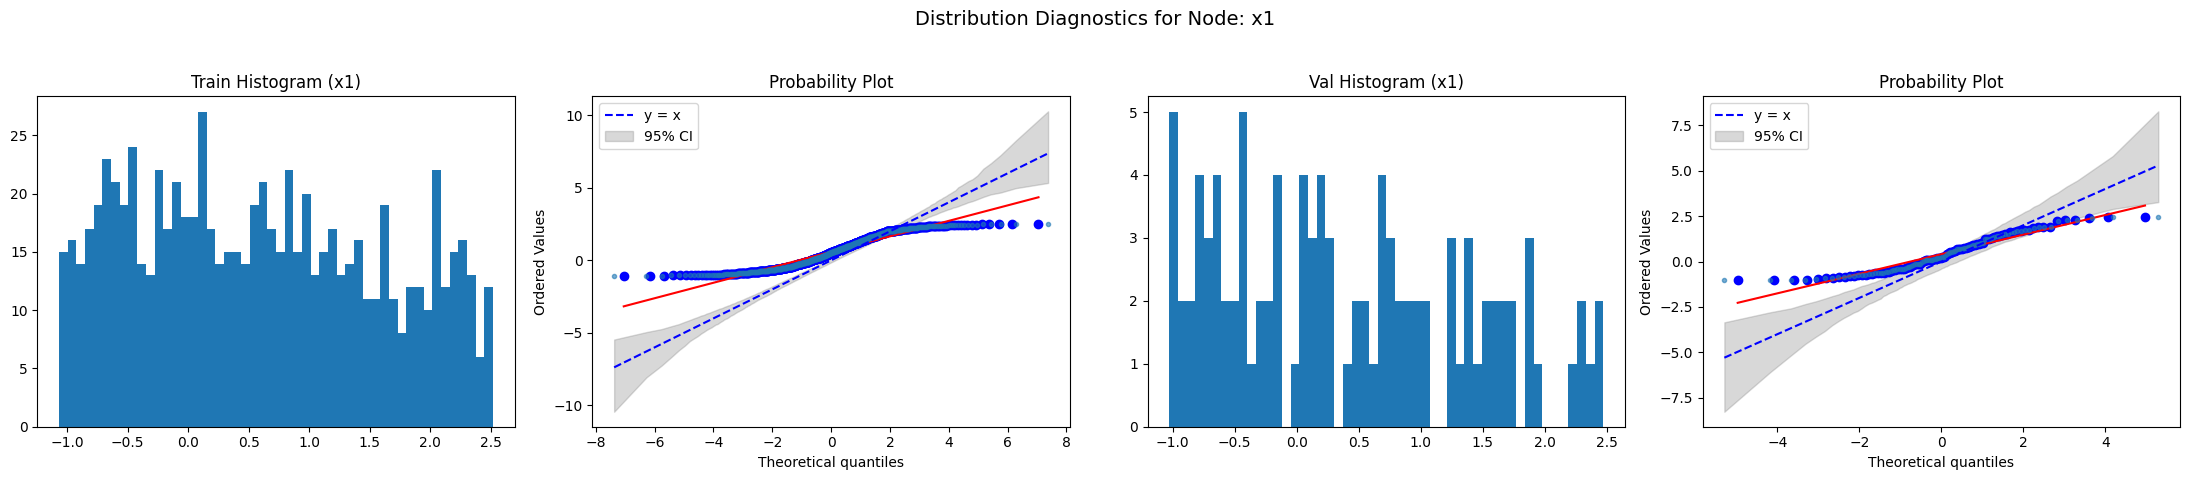

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


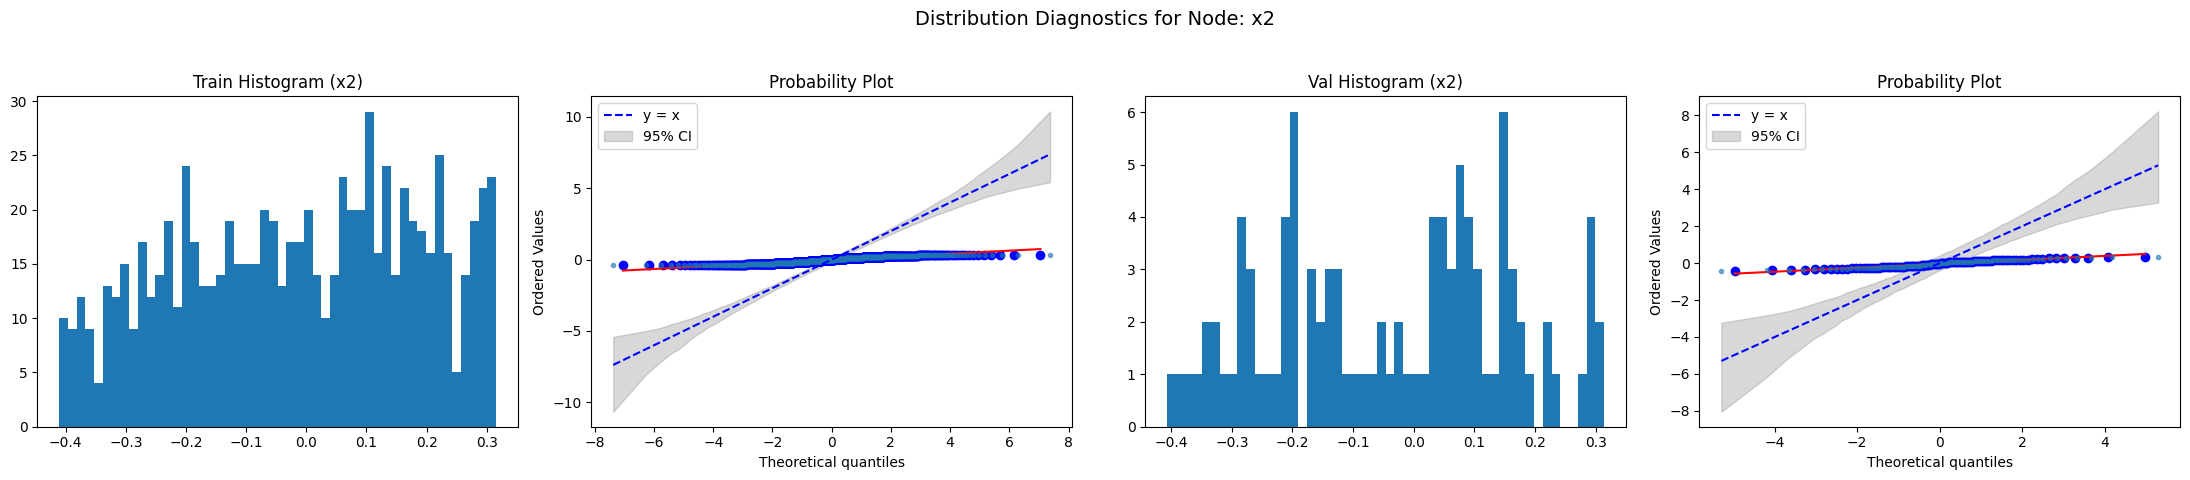

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


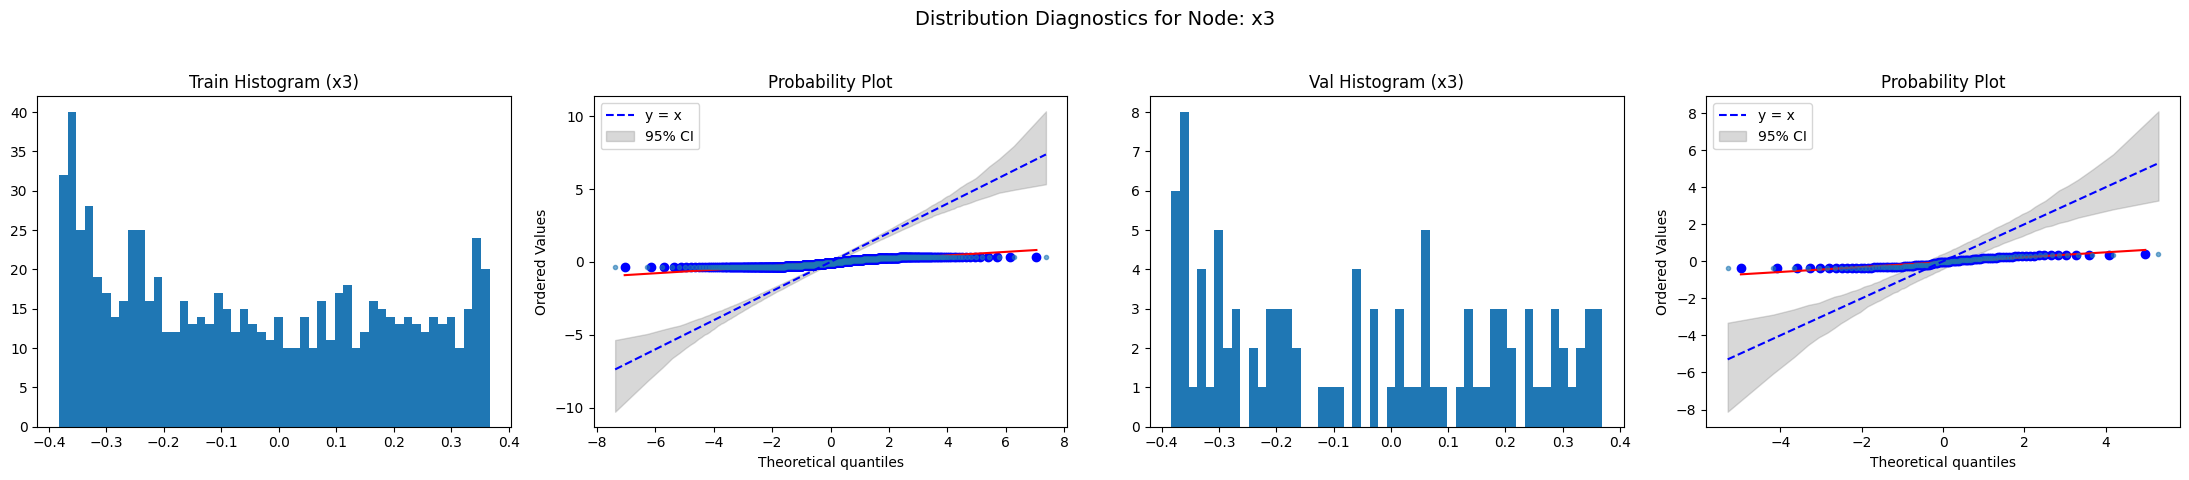

----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


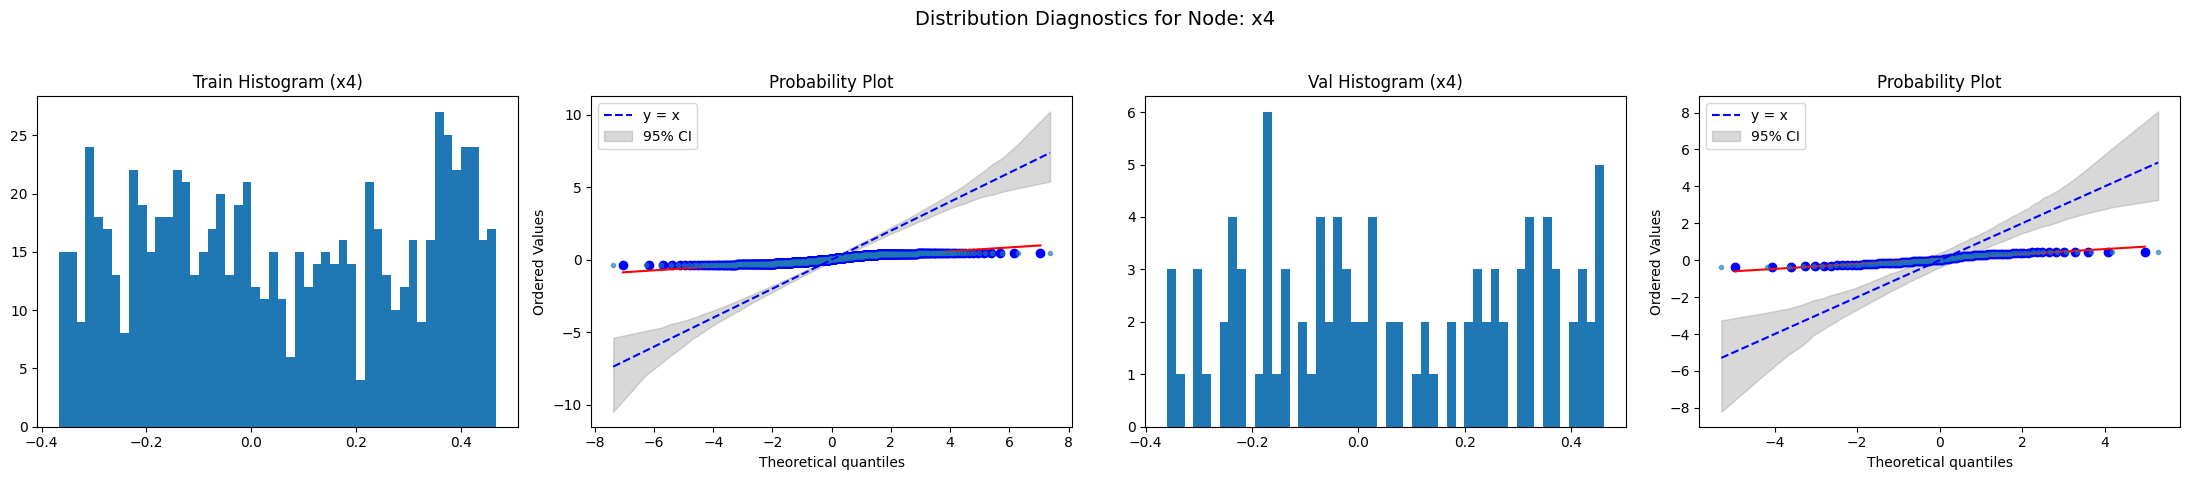

----*----------*-------------*--------h(data) should be standard logistic: x5 ------------*-----------------*-------------------*--


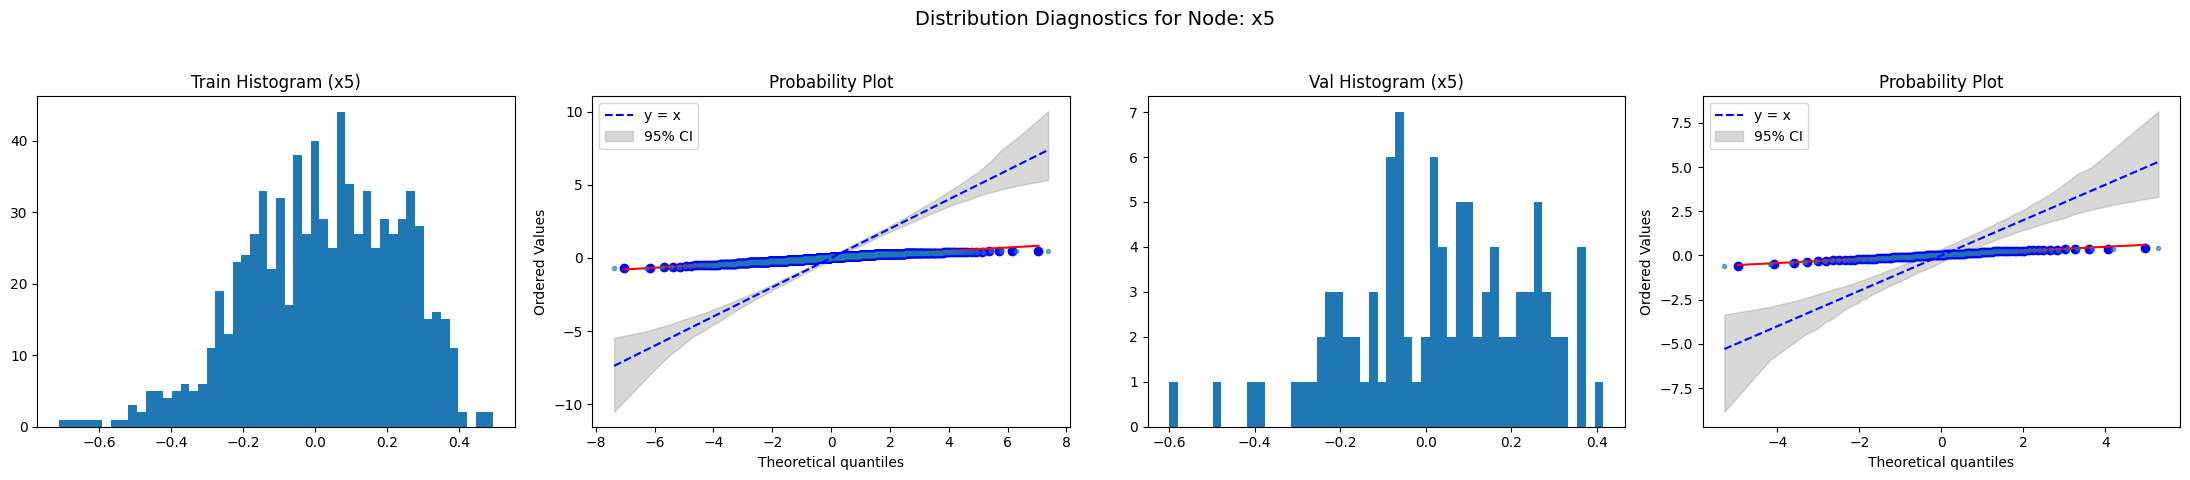

----*----------*-------------*--------h(data) should be standard logistic: x6 ------------*-----------------*-------------------*--


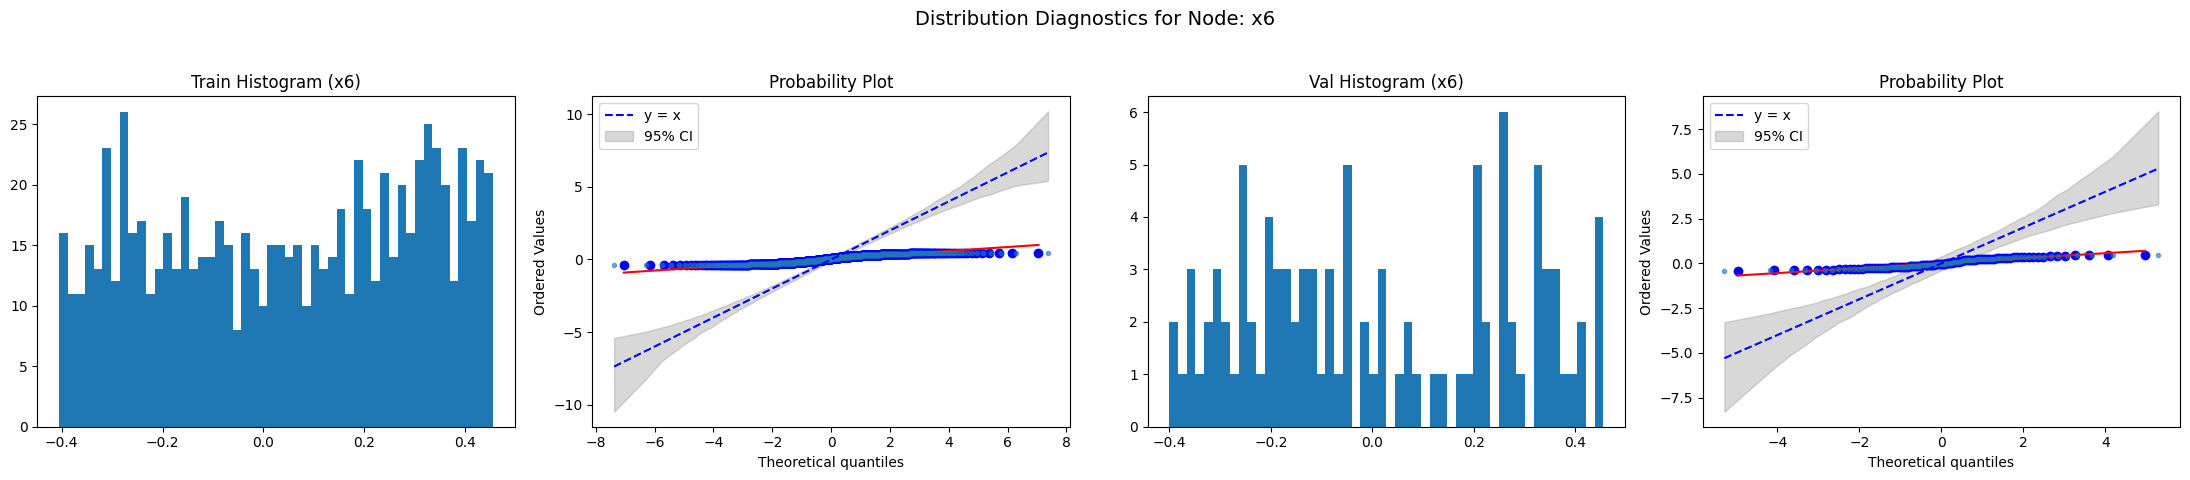

----*----------*-------------*--------h(data) should be standard logistic: x7 ------------*-----------------*-------------------*--


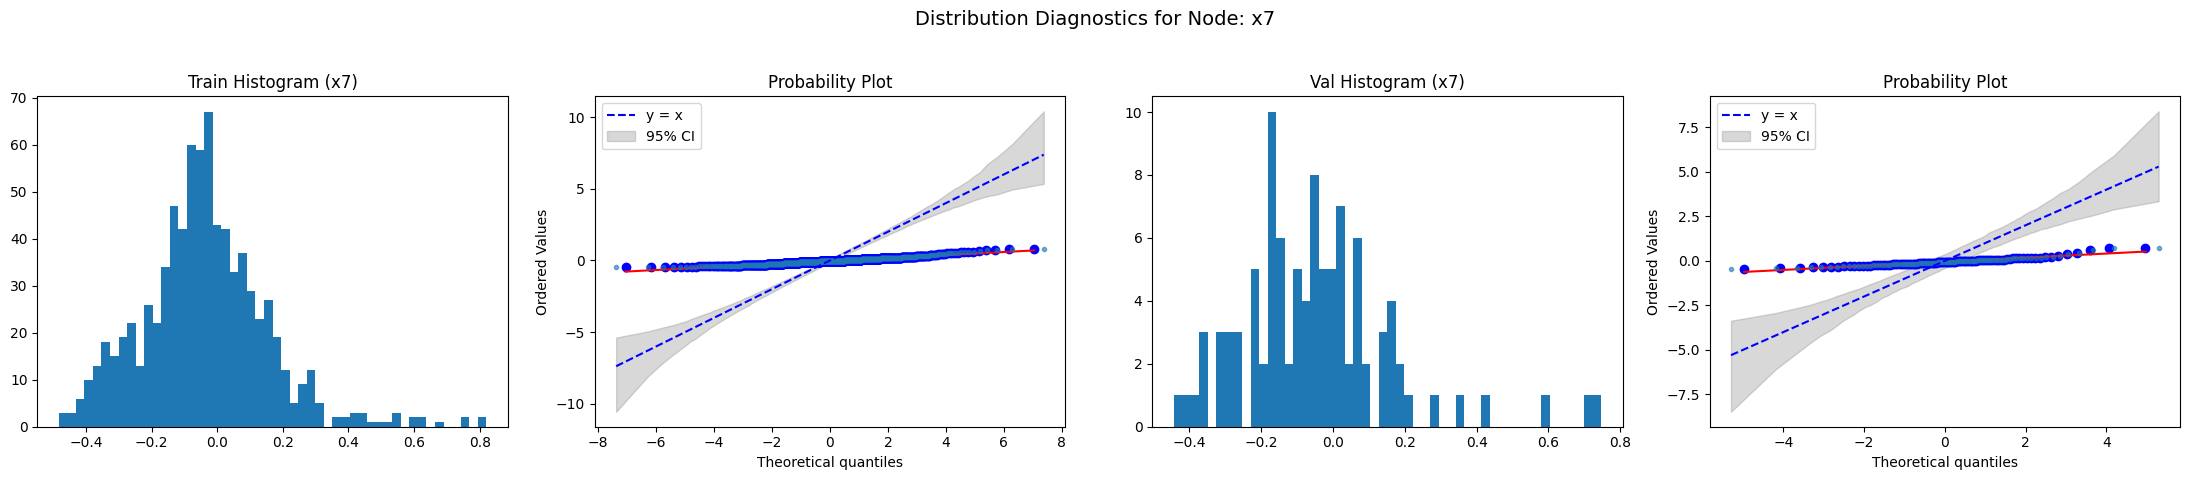

----*----------*-------------*--------h(data) should be standard logistic: x8 ------------*-----------------*-------------------*--


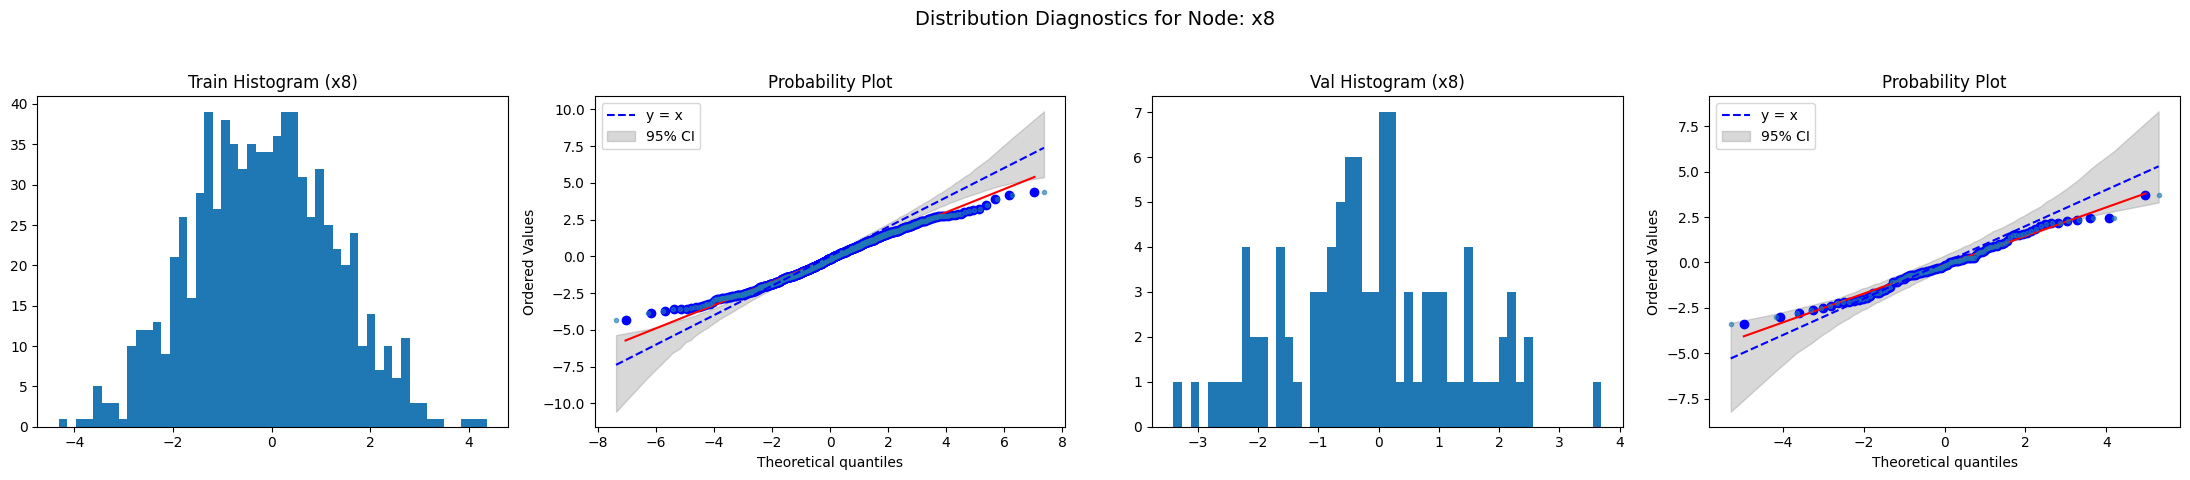

In [14]:
inspect_trafo_standart_logistic_v3(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)


# 7. Sample from Graph

In [15]:
target_nodes


{'x1': {'Modelnr': 0,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 0.10363289207947188,
  'max': 1.8947268989877821,
  'transformation_term_nn_models_in_h()': {}},
 'x2': {'Modelnr': 1,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 0.0961770772163077,
  'max': 1.9152953885721604,
  'transformation_term_nn_models_in_h()': {}},
 'x3': {'Modelnr': 2,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 0.1021798258863887,
  'max': 1.9121695544111017,
  'transformation_term_nn_models_in_h()': {}},
 'x4': {'Modelnr': 3,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 0.1012176500081761,
  'max': 1.87272970393435,
  'trans

In [16]:
class GenericDataset_v6(Dataset):
    def __init__(
        self,
        df,
        target_col,
        target_nodes=None,

        transform=None,
        return_intercept_shift=True,
        return_y=True,
        debug=False
    ):
        """
        df: pd.DataFrame
        target_col: str
        target_nodes: dict mapping each node → metadata (including 'data_type', 'levels', 'node_type')
        parents_datatype_dict: dict var_name → "cont"|"ord"|"other"
        transformation_terms_in_h: dict for intercept logic
        return_intercept_shift: whether to return (int_input, shift_list) or raw features
        transform: torchvision transform for images
        return_y: whether to return target y
        debug: bool to enable debug logging and attribute printouts
        """
        # initialize debug 
        self._set_debug(debug)

        # set attributes via dedicated setters
        self._set_df(df)
        self._set_target_col(target_col)
        self._set_target_nodes(target_nodes)
        self._set_ordered_parents_datatype_and_transformation_terms()

        self._set_predictors()
        self._set_transform(transform)

        self._set_h_needs_simple_intercept()
        self._set_target_data_type()
        self._set_target_num_classes()
        self.return_intercept_shift = return_intercept_shift
        self.return_y = return_y

        # intercept and shift
        if self.return_intercept_shift:
            self._set_intercept_shift_indexes()

        # source/ordinal
        self._set_target_is_source()
        self._set_ordinal_numal_classes()

        # checks
        self._check_multiclass_predictors_of_df()
        self._check_ordinal_levels()

    # Setter methods
    def _set_ordered_parents_datatype_and_transformation_terms(self):
        
        ordered_parents_datatype, ordered_transformation_terms_in_h, _ =ordered_parents(self.target_col, self.target_nodes)
        if not isinstance(ordered_parents_datatype, dict):
            raise TypeError(f"parents_datatype_dict must be dict, got {type(ordered_parents_datatype)}")
        self.parents_datatype_dict = ordered_parents_datatype
        
        if self.debug:
            print(f"[DEBUG] Set parents_datatype_dict: type={type(self.parents_datatype_dict)}, keys={list(self.parents_datatype_dict.keys())}")

        if ordered_transformation_terms_in_h is None:
            ordered_transformation_terms_in_h = {}
        if not isinstance(ordered_transformation_terms_in_h, dict):
            raise TypeError(f"transformation_terms_in_h must be dict, got {type(ordered_transformation_terms_in_h)}")
        self.transformation_terms_preprocessing = list(ordered_transformation_terms_in_h.values())
        if self.debug:
            print(f"[DEBUG] Set transformation_terms_preprocessing: type={type(self.transformation_terms_preprocessing)}, value={self.transformation_terms_preprocessing}")
    
    
    def _set_debug(self, debug):
        if not isinstance(debug, bool):
            raise TypeError(f"debug must be bool, got {type(debug)}")
        self.debug = debug
        if self.debug:
            print(f"[DEBUG] Set debug: type={type(self.debug)}, value={self.debug}")

    def _set_df(self, df):
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"df must be a pandas DataFrame, got {type(df)}")
        self.df = df.reset_index(drop=True)
        if self.debug:
            print(f"[DEBUG] Set df: type={type(self.df)}, shape={self.df.shape}")


    def _set_target_col(self, target_col):
        if not isinstance(target_col, str):
            raise TypeError(f"target_col must be str, got {type(target_col)}")
        
        if target_col not in self.df.columns:
            print(
                f"[WARNING] target_col '{target_col}' not in DataFrame columns — is this intended for use as a Sampler?")
            if self.debug:
                print(f"[DEBUG] target_col '{target_col}' not found in DataFrame columns")
            # Still set it in case it's needed for Sampler or other logic
            self.target_col = target_col
            return

        self.target_col = target_col
        if self.debug:
            print(f"[DEBUG] Set target_col: type={type(self.target_col)}, value={self.target_col}")


    def _set_target_nodes(self, target_nodes):
        if target_nodes is None:
            target_nodes = {}
        if not isinstance(target_nodes, dict):
            raise TypeError(f"target_nodes must be dict, got {type(target_nodes)}")
        self.target_nodes = target_nodes
        if self.debug:
            print(f"[DEBUG] Set target_nodes: type={type(self.target_nodes)}, keys={list(self.target_nodes.keys())}")


    def _set_predictors(self):
        self.predictors = list(self.parents_datatype_dict.keys())
        if self.debug:
            print(f"[DEBUG] Set predictors: type={type(self.predictors)}, value={self.predictors}")

    def _set_transform(self, transform):
        self.transform = transform
        if self.debug:
            print(f"[DEBUG] Set transform: type={type(self.transform)}, value={self.transform}")


    def _set_h_needs_simple_intercept(self):
        self.h_needs_simple_intercept = all('i' not in str(v) for v in self.transformation_terms_preprocessing)
        if self.debug:
            print(f"[DEBUG] Set h_needs_simple_intercept: type={type(self.h_needs_simple_intercept)}, value={self.h_needs_simple_intercept}")

    def _set_target_data_type(self):
        dtype = self.target_nodes.get(self.target_col, {}).get('data_type', '')
        self.target_data_type = dtype.lower()
        if self.debug:
            print(f"[DEBUG] Set target_data_type: type={type(self.target_data_type)}, value={self.target_data_type}")

    def _set_target_num_classes(self):
        levels = self.target_nodes.get(self.target_col, {}).get('levels')
        if levels is not None and not isinstance(levels, int):
            raise TypeError(f"levels must be int, got {type(levels)}")
        self.target_num_classes = levels
        if self.debug:
            print(f"[DEBUG] Set target_num_classes: type={type(self.target_num_classes)}, value={self.target_num_classes}")
            
    def _set_target_is_source(self):
        # determine if target node is a source
        node_type = self.target_nodes.get(self.target_col, {}).get('node_type', '')
        if not isinstance(node_type, str):
            raise TypeError(f"node_type metadata must be str, got {type(node_type)}")
        self.target_is_source = node_type.lower() == 'source'
        if self.debug:
            print(f"[DEBUG] Set target_is_source: type={type(self.target_is_source)}, value={self.target_is_source}")

    def _set_ordinal_numal_classes(self):
        # compute number of classes for each ordinal-xn predictor
        mapping = {}
        for v in self.predictors:
            dt = self.parents_datatype_dict[v]
            if not isinstance(dt, str):
                raise TypeError(f"datatype for predictor '{v}' must be str, got {type(dt)}")
            if 'ordinal' in dt.lower() and 'xn' in dt.lower():
                if v not in self.df.columns:
                    raise ValueError(f"Predictor column '{v}' not in DataFrame")
                mapping[v] = self.df[v].nunique()
        self.ordinal_num_classes = mapping
        if self.debug:
            print(f"[DEBUG] Set ordinal_num_classes: type={type(self.ordinal_num_classes)}, value={self.ordinal_num_classes}")

    def get_sort_key(self, val):
            """Map each transformation value to a sorting index."""
            order = ['ci', 'ciXX', 'cs', 'csXX', 'ls']
            
            base = re.match(r'[a-zA-Z]+', val)
            digits = re.findall(r'\d+', val)
            base = base.group(0) if base else ''
            digits = int(digits[0]) if digits else -1

            if base in ['ci', 'cs'] and digits != -1:
                # For ciXX/csXX
                return (order.index(base + 'XX'), digits)
            elif base in order:
                return (order.index(base), -1)
            else:
                return (len(order), digits)  # unknown terms go last

    def ordered_parents(self,node, target_dict) -> dict:
        
        """
        Orders the transformation terms and their corresponding data types and nn models used for the models and the dataloader
        """
        # Extract dictionaries
        transformation_terms = target_dict[node]['transformation_terms_in_h()']
        datatype_dict = target_dict[node]['parents_datatype']
        nn_models_dict = target_dict[node]['transformation_term_nn_models_in_h()']

        # Sort the items based on the transformation_terms
        sorted_keys = sorted(transformation_terms.keys(), key=lambda k: self.get_sort_key(transformation_terms[k]))

        # Create ordered dicts
        ordered_transformation_terms_in_h = OrderedDict((k, transformation_terms[k]) for k in sorted_keys)
        ordered_parents_datatype = OrderedDict((k, datatype_dict[k]) for k in sorted_keys)
        ordered_transformation_term_nn_models_in_h = OrderedDict((k, nn_models_dict[k]) for k in sorted_keys)

        return ordered_parents_datatype, ordered_transformation_terms_in_h, ordered_transformation_term_nn_models_in_h

    # Core methods
    def _set_intercept_shift_indexes(self):
        if not any('ci' in t for t in self.transformation_terms_preprocessing):
            self.transformation_terms_preprocessing.insert(0, 'si')
            if self.debug:
                print("[DEBUG] Inserted simple intercept term 'si'")
        self.intercept_indices = [i for i, term in enumerate(self.transformation_terms_preprocessing)
                                    if term.startswith(('si', 'ci'))]
        if self.debug:
            print(f"[DEBUG] Intercept indices: {self.intercept_indices}")
        self.shift_groups_indices = []
        current_key = None
        for i, term in enumerate(self.transformation_terms_preprocessing):
            if term.startswith(('cs', 'ls')):
                if len(term) > 2 and term[2].isdigit():
                    grp = term[:3]
                    if not self.shift_groups_indices or current_key != grp:
                        self.shift_groups_indices.append([i])
                        current_key = grp
                    else:
                        self.shift_groups_indices[-1].append(i)
                else:
                    self.shift_groups_indices.append([i])
                    current_key = None
        if self.debug:
            print(f"[DEBUG] Shift group indices: {self.shift_groups_indices}")

    def _preprocess_inputs(self, x):
        its = [x[i] for i in self.intercept_indices]
        if not its:
            raise ValueError("No intercept tensors found!")
        int_inputs = torch.cat([t.view(t.shape[0], -1) for t in its], dim=1)
        shifts = []
        for grp in self.shift_groups_indices:
            parts = [x[i].view(x[i].shape[0], -1) for i in grp]
            shifts.append(torch.cat(parts, dim=1))
        return int_inputs, (shifts if shifts else None)

    def _transform_y(self, row):
        if self.target_data_type in ('continous',) or 'yc' in self.target_data_type:
            return torch.tensor(row[self.target_col], dtype=torch.float32)
        elif self.target_num_classes:
            yi = int(row[self.target_col])
            return F.one_hot(
                torch.tensor(yi, dtype=torch.long),
                num_classes=self.target_num_classes
            ).float().squeeze()
        else:
            raise ValueError(
                f"Cannot encode target '{self.target_col}': {self.target_data_type}/{self.target_num_classes}"
            )
    #checks
    
    def _check_multiclass_predictors_of_df(self):
        for v in self.predictors:
            dt = self.parents_datatype_dict[v].lower()
            if 'ordinal' in dt and 'xn' in dt:
                vals = set(self.df[v].dropna().unique())
                if vals != set(range(len(vals))):
                    raise ValueError(
                        f"Ordinal predictor '{v}' must be zero‑indexed; got {sorted(vals)}"
                    )

    def _check_ordinal_levels(self):
        ords = []
        if 'ordinal' in self.target_nodes.get(self.target_col, {}).get('data_type', '').lower():
            ords.append(self.target_col)
        ords += [
            v for v in self.predictors
            if 'ordinal' in self.parents_datatype_dict[v].lower()
            and 'xn' in self.parents_datatype_dict[v].lower()
        ]
        for v in ords:
            lvl = self.target_nodes[v].get('levels')
            if lvl is None:
                raise ValueError(f"Ordinal '{v}' missing 'levels' metadata.")
            uniq = sorted(self.df[v].dropna().unique())
            if uniq != list(range(lvl)):
                raise ValueError(
                    f"Ordinal '{v}' values {uniq} != expected 0…{lvl-1}."
                )



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x_data = []

        # for source nodes the dataset gets just a 1.0
        if self.h_needs_simple_intercept:
            x_data.append(torch.tensor(1.0))
        
        # id target is a source node, return the x_data and y
        if self.target_is_source:
            
            if not self.return_intercept_shift:
                if self.return_y:
                    y = self._transform_y(row)
                    return (tuple(x_data), y)
                else:
                    return tuple(x_data)
            
            batched = [x.unsqueeze(0) for x in x_data]
            int_in, shifts = self._preprocess_inputs(batched)
            int_in = int_in.squeeze(0)
            shifts = [] if shifts is None else [s.squeeze(0) for s in shifts]
            if self.return_y:
                y = self._transform_y(row)
                return ((int_in, shifts), y)
            else:
                return (int_in, shifts)

        # predictors X 
        for var in self.predictors:
            dt = self.parents_datatype_dict[var].lower()
            if dt in ('continous',) or 'xc' in dt:
                x_data.append(torch.tensor(row[var], dtype=torch.float32))
            elif 'ordinal' in dt and 'xn' in dt:
                c = self.ordinal_num_classes[var]
                o = int(row[var])
                x_data.append(
                    F.one_hot(torch.tensor(o, dtype=torch.long), num_classes=c).float().squeeze()
                )
            else:
                img = Image.open(row[var]).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                x_data.append(img)

        if not self.return_intercept_shift:
            if self.return_y:
                y = self._transform_y(row)
                return tuple(x_data), y
            else:
                return tuple(x_data)

        batched = [x.unsqueeze(0) for x in x_data]
        int_in, shifts = self._preprocess_inputs(batched)
        int_in = int_in.squeeze(0)
        shifts = [] if shifts is None else [s.squeeze(0) for s in shifts]
        if self.return_y:
            y = self._transform_y(row)
            return (int_in, shifts), y
        return int_in, shifts



def get_dataloader_v6(node, target_nodes, train_df, val_df, batch_size=32,return_intercept_shift=False, verbose=False):
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    train_ds = GenericDataset_v6(train_df,target_col=node,target_nodes=target_nodes,transform=transform,return_intercept_shift=return_intercept_shift)
    val_ds = GenericDataset_v6(val_df,target_col=node,target_nodes=target_nodes,transform=transform,return_intercept_shift=return_intercept_shift)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [ ]:

def create_df_from_sampled(node, target_nodes_dict, num_samples, EXPERIMENT_DIR):
    sampling_dict = {}

    # Add dummy variable
    sampling_dict["DUMMY"] = torch.zeros(num_samples)

    # Try loading sampled values for each parent
    for parent in target_nodes_dict[node].get('parents', []):
        path = os.path.join(EXPERIMENT_DIR, parent, "sampling", "sampled.pt")
        if os.path.exists(path):
            sampling_dict[parent] = torch.load(path)

    # Remove dummy if we have real variables
    if len(sampling_dict) > 1:
        sampling_dict.pop("DUMMY")

    # Move all tensors to CPU before creating the DataFrame
    sampling_dict_cpu = {k: v.cpu().numpy() for k, v in sampling_dict.items()}

    sampling_df = pd.DataFrame(sampling_dict_cpu)
    return sampling_df



def criteria_for_continous_modelled_outcome(node,target_nodes_dict):
    if 'yc'in target_nodes_dict[node]['data_type'].lower() or 'continous' in target_nodes_dict[node]['data_type'].lower():
        return True
    else:
        return False

def criteria_for_ordinal_modelled_outcome(node,target_nodes_dict):
    if 'yo'in target_nodes_dict[node]['data_type'].lower() and 'ordinal' in target_nodes_dict[node]['data_type'].lower():
        return True
    else:
        return False  
    
    
def sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample,verbose=True):
    
        
    number_of_samples = len(latent_sample)
    
    output_list = []
    with torch.no_grad():
        
        
        # for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
        #     shift_list,int_input = x
        #     model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            
            
        for (int_input, shift_list) in sample_loader:
            # Move everything to device
            int_input = int_input.to(device)
            shift_list = [s.to(device) for s in shift_list]
            model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            # print(f"model_outputs {model_outputs}")
            
            output_list.append(model_outputs)
            
    if target_nodes_dict[node]['node_type'] == 'source':
        if verbose:
            print("source node, Defaults to SI and 1 as inputs")
        theta_single = output_list[0]['int_out'][0]
        theta_single = transform_intercepts_continous(theta_single)
        thetas_expanded = theta_single.repeat(number_of_samples, 1)
        shifts = torch.zeros(number_of_samples, device=device)
    else:
        if verbose:
            print("node has parents, previously sampled data is loaded for each pa(node)")
        y_pred = merge_outputs(output_list, skip_nan=True)
        shifts = y_pred['shift_out']
        if shifts is None:
            print("shift_out was None; defaulting to zeros.")
            shifts = torch.zeros(number_of_samples, device=device)
        thetas = y_pred['int_out']
        thetas_expanded = transform_intercepts_continous(thetas).squeeze()
        shifts = shifts.squeeze()
    
    low = torch.full((number_of_samples,), -1e5, device=device)
    high = torch.full((number_of_samples,), 1e5, device=device)
    min_vals = torch.tensor(target_nodes_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(target_nodes_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)
    
    ## Root finder using Chandrupatla's method
    def f_vectorized(targets):
        return vectorized_object_function(
            thetas_expanded,
            targets,
            shifts,
            latent_sample,
            k_min=min_max[0],
            k_max=min_max[1]
        )
        
    sampled = chandrupatla_root_finder(
        f_vectorized,
        low,
        high,
        max_iter=10_000,
        tol=1e-9
    )
    return sampled

def check_sampled_and_latents_v2(NODE_DIR,verbose=True):
    root_path = os.path.join(NODE_DIR, 'sampling',f"sampled.pt")
    latents_path=os.path.join(NODE_DIR, 'sampling', "latents.pt")
    if os.path.exists(root_path) and os.path.exists(latents_path):
        return True
    else:
        if verbose:
            print(f'sampled or latent files not found in {os.path.join(NODE_DIR,"sampling")}')
        return False
    
    
def sample_ordinal_modelled_target(node,target_nodes_dict,sample_loader,tram_model):
    print('not implemented yet')
    
    
def sample_full_dag_chandru_v2(target_nodes_dict,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            number_of_samples= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    """
    Samples data for all nodes in a DAG defined by `conf_dict`, ensuring that each node's
    parents are sampled before the node itself. Supports interventions on any subset of nodes.

    Parameters
    ----------
    conf_dict : dict
        Dictionary defining the DAG. Each key is a node name, and each value is a config
        dict that includes at least:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node

    EXPERIMENT_DIR : str
        Base directory where all per-node directories are located.

    device : torch.device
        The device to run computations on (e.g., 'cuda' or 'cpu').

    do_interventions : dict, optional
        A dictionary specifying interventions for some nodes. Keys are node names (str),
        values are floats. For each intervened node, the specified value is used as the
        sampled value for all samples, and the model is bypassed. e.g. {'x1':1.0}

    n : int, optional
        Number of samples to draw for each node (default is 10_000).

    batch_size : int, optional
        Batch size for model evaluation during sampling (default is 32).

    delete_all_previously_sampled : bool, optional
        If True, removes previously sampled data before starting (default is True).

    verbose : bool, optional
        If True, prints debug/status information (default is True).

    Notes
    -----
    - The function ensures that nodes are only sampled after their parents.
    - Nodes with `node_type='source'` are treated as having no parents.
    - If a node is in `do_interventions`, `sampled_chandrupatla.pt` and a dummy `latents.pt`
      are created, enabling downstream nodes to proceed.
    - Sampling is done using a vectorized root-finding method (Chandrupatla's algorithm).
    """

    if delete_all_previously_sampled:
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    # # repeat process until all nodes are sampled

    max_iterations=200
    iteration=0
    processed_nodes=[] # log the processed nodes in this list
    while set(processed_nodes) != set(target_nodes_dict.keys()): 
        iteration += 1
        if iteration > max_iterations:
            raise RuntimeError("Too many iterations in sampling loop, possible infinite loop.")
        
        for node in target_nodes_dict: # for each node in the target_nodes_dict
            if node in processed_nodes:
                if verbose :
                    print('node is already  in sampled list')
                continue
                        
            print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
            ## 1. Paths 
            NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
            SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
            os.makedirs(SAMPLING_DIR, exist_ok=True)
            SAMPLED_PATH = os.path.join(SAMPLING_DIR, "sampled.pt")
            LATENTS_PATH = os.path.join(SAMPLING_DIR, "latents.pt")
            
            ## 2. Check if sampled and latents already exist 
            if check_sampled_and_latents_v2(NODE_DIR, verbose=verbose):
                processed_nodes.append(node)
                continue
            
            ## 3. logic to make sure parents are always sampled first
            skipping_node = False
            if target_nodes_dict[node]['node_type'] != 'source':
                for parent in target_nodes_dict[node]['parents']:
                    if not check_sampled_and_latents_v2(os.path.join(EXPERIMENT_DIR, parent), verbose=verbose):
                        skipping_node = True
                        break
                    
            if skipping_node:
                print(f"Skipping {node} as parent {parent} is not sampled yet.")
                continue
            
            ## INTERVENTION, if node is to be intervened on , data is just saved
            if do_interventions and node in do_interventions.keys():
                    # For interventions make all the values the same for 
                    intervention_value = do_interventions[node]
                    intervention_vals = torch.full((number_of_samples,), intervention_value)
                    torch.save(intervention_vals, SAMPLED_PATH)
                    
                    ### dummy latents jsut for the check , not needed
                    dummy_latents = torch.full((number_of_samples,), float('nan'))  
                    torch.save(dummy_latents, LATENTS_PATH)
                    processed_nodes.append(node)
                    print(f'Interventional data for node {node} is saved')
                    continue  
                ##### %%%%%%% no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
            else:
                ### sampling latents
                latent_sample = torch.tensor(logistic.rvs(size=number_of_samples), dtype=torch.float32).to(device)
                
                ### load modelweights
                MODEL_PATH = os.path.join(NODE_DIR, "best_model.pt")
                tram_model = get_fully_specified_tram_model_v5(node, target_nodes, verbose=True).to(device)
                tram_model.load_state_dict(torch.load(MODEL_PATH))
                
                # isntead of sample loader use Generic Dataset but the df is just to sampled data from befor -> create df for each node
                sampled_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)
                
                sample_dataset = GenericDataset_v6(sampled_df,target_col=node,
                                                    target_nodes=target_nodes,
                                                    return_intercept_shift=True,
                                                    return_y=False,
                                                    debug=False)
                
                sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
                
                ###*************************************************** Continous Modelled Outcome ************************************************
                
                if criteria_for_continous_modelled_outcome(node,target_nodes_dict):
                    sampled=sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample)
                    
                ###*************************************************** Ordinal Modelled Outcome ************************************************
                
                elif criteria_for_ordinal_modelled_outcome(node,target_nodes_dict):
                    sampled=sample_ordinal_modelled_target(node,target_nodes_dict,sample_loader,tram_model)
                
                else:
                    raise ValueError(f"Unsupported data_type '{target_nodes_dict[node]['data_type']}' for node '{node}' in sampling.")
                    
                ###*************************************************** Saving the latenst and sampled  ************************************************
                if torch.isnan(sampled).any():
                    print(f'Caution! Sampling for {node} consists of NaNs')
                    
                torch.save(sampled, SAMPLED_PATH)
                torch.save(latent_sample, LATENTS_PATH)
                
                processed_nodes.append(node)          


checking dataset loader for sampling

In [39]:
sample_full_dag_chandru_v2(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            number_of_samples= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

NameError: name 'sample_full_dag_chandru_v2' is not defined

Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x4/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x5/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x6/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x7/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x8/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x1/sampling
[WARNING]

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 334.95it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x2/sampling
[WARNING] target_col 'x2' not in DataFrame columns — is this intended for use as a Sampler?
source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 341.93it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x3/sampling
[WARNING] target_col 'x3' not in DataFrame columns — is this intended for use as a Sampler?


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 344.18it/s]


----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x4/sampling
[WARNING] target_col 'x4' not in DataFrame columns — is this intended for use as a Sampler?


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 350.67it/s]


----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x5/sampling
[WARNING] target_col 'x5' not in DataFrame columns — is this intended for use as a Sampler?


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 350.34it/s]


----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x6/sampling
[WARNING] target_col 'x6' not in DataFrame columns — is this intended for use as a Sampler?


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 349.17it/s]


----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x7/sampling
[WARNING] target_col 'x7' not in DataFrame columns — is this intended for use as a Sampler?


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 345.39it/s]


----*----------*-------------*--------Sample Node: x8 ------------*-----------------*-------------------*--
sampled or latent files not found in /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/x8/sampling
[WARNING] target_col 'x8' not in DataFrame columns — is this intended for use as a Sampler?


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 345.34it/s]


## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')